In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd       # mxnet中的autograd可以直接后向求梯度，比较方便本次作业
import numpy as np
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征$\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重$\boldsymbol{w} = [2, -3.4]^\top$和偏差$b = 4.2$，以及一个随机噪声项$\epsilon$来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 100
test_examples = 100
true_w = [2, -3.4]
true_b = 4.2

# 训练集
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
# 测试集
features_test = nd.random.normal(scale=1, shape=(test_examples, num_inputs))
labels_test = true_w[0] * features_test[:, 0] + true_w[1] * features_test[:, 1] + true_b
labels_test += nd.random.normal(scale=0.01, shape=labels_test.shape)

通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

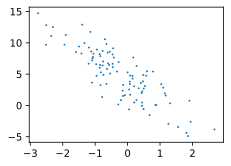

In [3]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`dot`函数做矩阵乘法。

In [5]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

## 定义损失函数

使用`MSE`损失函数

In [6]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

## 定义优化算法

以下的`sgd`函数小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个***批量样本的梯度和***。我们将它除以批量大小来得到平均值。

In [7]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh包中方便以后使用
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [8]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度的存放空间。
w.attach_grad()
b.attach_grad()

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。由于变量`l`并不是一个标量，运行`l.backward()`将对`l`中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。

In [9]:
# 如果需要多次运行该cell，需要重新从初始化模型参数开始运行，否则将会从上一次运行得到的参数开始迭代
lr = 0.02
num_epochs = 10
batch_size = 10
net = linreg
loss = squared_loss
train_err = []
test_err = []

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        train_l = loss(net(features, w, b), labels)
        train_err.append(train_l.mean().asscalar())  # 每次小批量的SGD后的训练误差

    train_l = loss(net(features, w, b), labels)    # 一次训练后的训练误差
    test_l = loss(net(features_test, w, b), labels_test)    # 一次训练后的预测误差
    print('epoch %d, train loss %f, test loss %f' % (epoch + 1, train_l.mean().asnumpy(), test_l.mean().asnumpy()))
    test_err.append(test_l.mean().asscalar())
print('true_w:', true_w, 'w:', w.asnumpy().tolist())
print('true_b:', true_b, 'b:', b.asnumpy().tolist())

epoch 1, train loss 14.667944, test loss 13.503239
epoch 2, train loss 5.369067, test loss 5.081339
epoch 3, train loss 2.010958, test loss 1.954374
epoch 4, train loss 0.766376, test loss 0.768332
epoch 5, train loss 0.298736, test loss 0.309158
epoch 6, train loss 0.119751, test loss 0.128068
epoch 7, train loss 0.049497, test loss 0.054589
epoch 8, train loss 0.021127, test loss 0.023931
epoch 9, train loss 0.009324, test loss 0.010778
epoch 10, train loss 0.004268, test loss 0.004982
true_w: [2, -3.4] w: [[1.9727497100830078], [-3.40985107421875]]
true_b: 4.2 b: [4.141231536865234]


## 绘制训练损失曲线和测试误差曲线

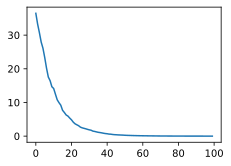

In [10]:
# 绘制训练损失曲线
plt.plot(np.array(range(len(train_err))), np.array(train_err));

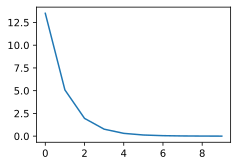

In [11]:
# 绘制测试误差曲线
plt.plot(np.array(range(len(test_err))), np.array(test_err));

## 不同模型容量的训练损失和样本误差

In [12]:
抱歉老师，暂时不同咋改模型容量，后续我在改改

SyntaxError: invalid character in identifier (<ipython-input-12-8d0a5b6fe668>, line 1)